# DC2 Run1.2 object catalog footprint (Spark)
<br> Kernel: **desc-pyspark**
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-11-27**
    
The goal of this notebook is to have a QA look a the dc2-data-access produced object_catalog (here on Run1.2i)
It also illustrates how simple and efficient Spark is.


## load the full Run1.2 catalog from parquet file

In [65]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

spark session started


In [66]:
object_catalog="/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/object_catalog/*.parquet"
df_all=spark.read.parquet(object_catalog)
df_all.printSchema()
print("#columns={}".format(len(df_all.columns)))

root
 |-- magerr_u: double (nullable = true)
 |-- psFlux_flag_u: boolean (nullable = true)
 |-- psFlux_flag_i: boolean (nullable = true)
 |-- mag_y: double (nullable = true)
 |-- magerr_g_cModel: double (nullable = true)
 |-- psFlux_flag_z: boolean (nullable = true)
 |-- psf_fwhm_u: double (nullable = true)
 |-- Ixx_y: double (nullable = true)
 |-- IxxPSF_z: double (nullable = true)
 |-- psFlux_r: double (nullable = true)
 |-- mag_r: double (nullable = true)
 |-- IxxPSF_r: double (nullable = true)
 |-- magerr_g: double (nullable = true)
 |-- IxyPSF_g: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- psFluxErr_y: double (nullable = true)
 |-- psFlux_flag_r: boolean (nullable = true)
 |-- mag_g_cModel: double (nullable = true)
 |-- IyyPSF_y: double (nullable = true)
 |-- mag_z_cModel: double (nullable = true)
 |-- x: double (nullable = true)
 |-- IxxPSF: double (nullable = true)
 |-- xy_flag: boolean (nullable = true)
 |-- ra: double (nullable = true)
 |-- magerr_y: dou

In [67]:
#select relevant columns (we alos add the filter flags)
cols=["tract","patch","ra","dec"]
for f in ['u','g','r','i','z','y']:
    s=["psFlux_flag_{}".format(f)]
    cols+=s
print(cols)

df=df_all.select(cols)
N=df.cache().count()
print("#galaxies={} millions".format(N/1e6))

['tract', 'patch', 'ra', 'dec', 'psFlux_flag_u', 'psFlux_flag_g', 'psFlux_flag_r', 'psFlux_flag_i', 'psFlux_flag_z', 'psFlux_flag_y']
#galaxies=3.183404 millions


## Look at tracts and patches

In [68]:
df.select("tract").distinct().count() #check that all the tracts are present

20

According to https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb This is OK. how many patches per tract?

In [69]:
df.groupBy(["tract","patch"]).count().groupBy("tract").count().\
withColumnRenamed("count","#patches").sort("tract").show()  #groupBy twice, rename and sort

+-----+--------+
|tract|#patches|
+-----+--------+
| 4429|      42|
| 4430|      56|
| 4431|      57|
| 4432|      55|
| 4433|       5|
| 4636|      16|
| 4637|      64|
| 4638|      64|
| 4639|      64|
| 4640|      48|
| 4848|      48|
| 4849|      64|
| 4850|      64|
| 4851|      64|
| 4852|      16|
| 5062|      15|
| 5063|      56|
| 5064|      56|
| 5065|      14|
| 5066|      34|
+-----+--------+



## (ra,dec) footprint

In [70]:
#are there some Nans?
import numpy as np
df.filter(df['ra'].contains(np.nan)).count()

0

No so lets do some basic statistics

In [71]:
df.describe(['ra','dec']).show()

+-------+------------------+-------------------+
|summary|                ra|                dec|
+-------+------------------+-------------------+
|  count|           3183404|            3183404|
|   mean| 54.83667395418485| -29.98888578265339|
| stddev|1.9042840926002418| 1.6088311401323847|
|    min| 51.74733347101702|-32.612948240756936|
|    max| 58.36326016759801|-26.954299775954787|
+-------+------------------+-------------------+



We will project galaxies in a Healpix map. For that we define a pandas User Defined Function to call healpy ang2pix function

In [72]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=2048
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [73]:
#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()
#statistics per pixel
df_map.describe(['count']).show() 

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            35845|
|   mean|88.81026642488492|
| stddev|46.58134006940346|
|    min|                1|
|    max|              414|
+-------+-----------------+



In [74]:
#back to python world
map_p=df_map.toPandas()

In [75]:
#now data is reduced create the healpy map
counts = np.full(hp.nside2npix(nside),hp.UNSEEN)
counts[map_p['ipix'].values]=map_p['count'].values

<Figure size 432x288 with 0 Axes>

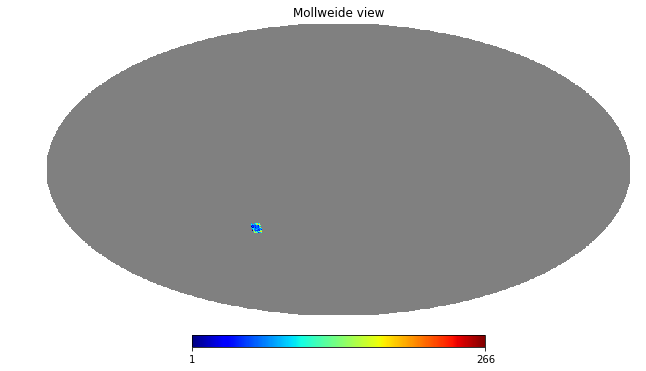

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet') #color-blind people should comment this line

hp.mollview(counts)

from the previous mean ra/dec and count statistics we can zoom on the center and perform a gnomonic projection

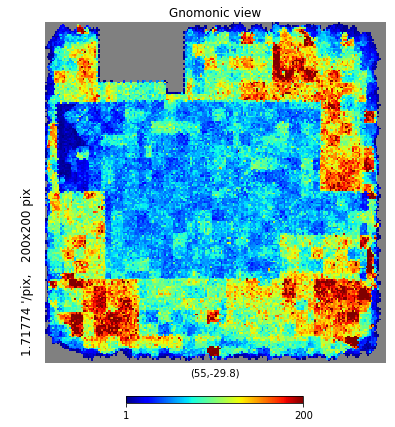

In [77]:
hp.gnomview(counts,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),max=200)

Tracts outline: 
for each tract build the map and flag pixels with some neighbours unseen (for superior minds only)

NSIDE=2048
4848-4636-4639-5065-5064-4637-4432-5063-4640-4433-4429-5066-4430-4638-4431-4851-4849-4852-5062-4850-

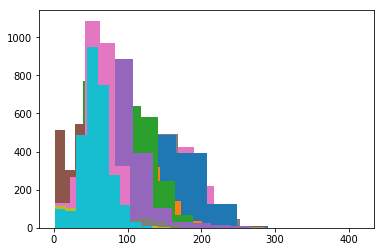

In [78]:
#list of tracts
tracts=df.select("tract").distinct().toPandas()
df_withpix=df.groupBy(["tract","ipix"]).count().cache()
ipix=np.arange(hp.nside2npix(nside))
pixborder=[]
print("NSIDE={}".format(nside))
for t in tracts['tract'].values :
    print(t,end='-')
    #create a map just for this tract
    df_map=df_withpix.filter(df_withpix.tract==int(t))
    #create the healpix map
    tract_p=df_map.toPandas()
    plt.hist(tract_p['count'].values)
    tract_map = np.full(hp.nside2npix(nside),hp.UNSEEN)
    tract_map[tract_p['ipix'].values]=1
    # for lit pixels compute the neighbours
    ipix1=tract_p['ipix'].values
    theta,phi=hp.pix2ang(nside,ipix1)
    neighbours=hp.get_all_neighbours(nside,theta,phi,0).transpose()
    # border if at least one neighbours is UNSEEN
    mask=[(hp.UNSEEN in tract_map[neighbours[pixel]]) for pixel in range(len(ipix1))]
    pixborder+=list(ipix1[mask])

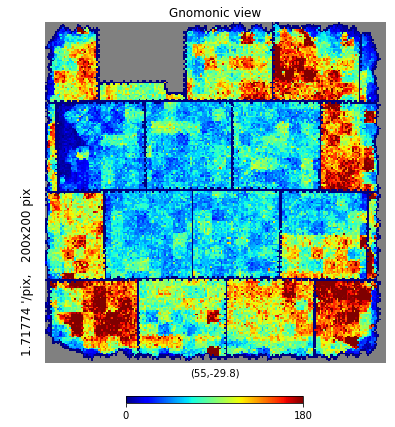

In [79]:
count_t=counts
count_t[pixborder]=-1
resol= hp.nside2resol(nside,arcmin=True)
hp.gnomview(count_t,rot=[55,-29.8],reso=resol,xsize=200,min=0,max=180)

## Filter data

most of data do not have any valid psFlug flag:

In [80]:
print("total number of objects= {} millions".format(df.count()/1e6))
dff=df.filter((df['psFlux_flag_u']==True) | \
            (df['psFlux_flag_g']==True) | \
            (df['psFlux_flag_r']==True) | \
            (df['psFlux_flag_i']==True) | \
            (df['psFlux_flag_z']==True) | \
            (df['psFlux_flag_y']==True))
print("#object with at least one filter= {} millions".format(dff.count()/1e6))

total number of objects= 3.183404 millions
#object with at least one filter= 0.523433 millions


does the densit map change for these?

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             20324|
|   mean| 25.75442826215312|
| stddev|39.150379554127184|
|    min|                 1|
|    max|               414|
+-------+------------------+



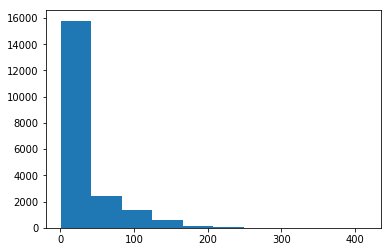

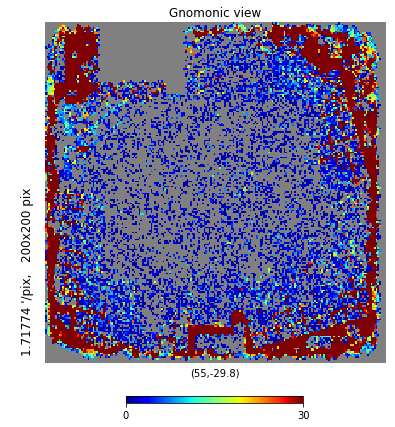

In [81]:
dff_map=dff.groupBy("ipix").count()
dff_map.describe(['count']).show() 
mapf_p=dff_map.toPandas()
plt.hist(mapf_p['count'].values)
counts_f = np.full(hp.nside2npix(nside),hp.UNSEEN)
counts_f[mapf_p['ipix'].values]=mapf_p['count'].values
#counts_f[pixborder]=-1
resol= hp.nside2resol(nside,arcmin=True)
hp.gnomview(counts_f,rot=[55,-29.8],reso=resol,min=0,max=30)